Module 5: Stokes Flow <br>
Laurie Stevens & Guillaume Palumbo <br>
Année 2016-2017

Nous allons ici nous pencher sur un flux de Stokes dans une cavité carrée (à deux dimensions). <br>
Nous nous trouvons dans une situation classique : trois des parois de la cavités sont immobiles, et seule le "couvercle" de la cavité se déplace, à une vitesse constante u=1. <br>
La cavité possède des parois de longueur 1, qu'on divisera en 40 intervalles égaux. Pour étudier la fonction d'onde et la vorticité au sein de la cavité, on va utiliser des arrays de taille 41x41, initialement nuls, qu'on remplira ensuite par la méthode de Jacobi. 

In [3]:
import numpy as np
from matplotlib import pyplot
%matplotlib inline

nx = 41
ny = 41

l = 1.0
h = 1.0

dx = l/(nx-1)
dy = h/(ny-1)

l1_target = 1e-6

omega_initial=np.zeros((41,41))
psi_initial=np.zeros((41,41))
u=np.zeros(41)
u[-1]=1.0

On définit maintenant l'array des valeurs de la fonction d'onde dans la cavité. On note que par les conditions de bord, la fonction est nulle à tous les bords sauf au bord supérieur. Quant aux valeurs hors du bord, on les obtient à partir de l'équation de poisson discrétisée donnant la vorticité comme le laplacien de la fonction d'onde : l'expression de la fonction d'onde en un point à l'itération suivante est donnée dans le notebook 2 sur la résolution de l'équation de Poisson en 2D.

In [3]:
def next_psi(old_omega,old_psi):
    new_psi = np.zeros((41,41))
    new_psi[1:-1,1:-1] = (1.0/(2.0*(pow(dx,2)+pow(dy,2))))*(((old_psi[2:,1:-1]+old_psi[:-2,1:-1])*pow(dx,2))+((old_psi[1:-1,2:]+old_psi[1:-1,:-2])*pow(dy,2))-(old_omega[1:-1,1:-1]*pow(dx,2)*pow(dy,2)))
    new_psi[0,:] = 0
    new_psi[-1,:] = 0
    new_psi[:,0] = 0
    new_psi[:,-1] = 0
    return new_psi

A partir des données obtenues pour la fonction d'onde et des valeurs initiales, on obtient les valeurs des la vorticité dans la cavité. Les valeurs le long du bord supérieur sont données par une formule donnée dans le notebook 5, quant aux valeurs le long du bord inférieur, on les obtient par un raisonnement semblable, dans lequel on tâche maintenant d'exprimer la valeur recherchée en fonction de termes supérieurs (sinon, on sort du domaine). Ces formules permettent en plus de ne pas se préoccuper des bords latéraux.

In [13]:
def next_omega(old_omega,old_psi,new_psi):
    new_omega = np.zeros((41,41))
    new_omega[1:-1,1:-1] = (1.0/(2*(pow(dx,2)+pow(dy,2)))) * (((old_omega[:-2,1:-1]+old_omega[2:,1:-1])*pow(dx,2))+((old_omega[1:-1,:-2]+old_omega[1:-1,2:])*pow(dy,2)))
    new_omega[-1,1:-1] = (-1.0/(2.0*dx*dx))*(8.0*new_psi[-2,1:-1]-new_psi[-3,1:-1])-(3.0*u[-1]/dx)
    new_omega[0,1:-1] = (-1.0/(2.0*dx*dx))*(8.0*new_psi[1,1:-1]-new_psi[2,1:-1])
    new_omega[:,0] = (-1.0/(2.0*dy*dy))*(8.0*new_psi[:,1]-new_psi[:,2])
    new_omega[:,-1] = ((-1.0/(2.0*dy*dy))*(8.0*new_psi[:,-2]-new_psi[:,-3]))

    return new_omega

On définit ici la norme L1 comme expliqué dans le notebook.

In [14]:
def L1norm(new, old):
    norm = np.sum(np.abs(new-old))
    return norm

On définit ici la fonction qui nous permet, à partir d'une boucle, de recalculer les matrices new_psi et new_omega jusqu'à ce que notre condition sur la norme L1 soit satisfaite. <br>
Vous pourrez noter que nous avons dû "forcer" certaines itérations. En effet, au tout début, lorsque le mécanisme se "met en route" la différence entre les normes des matrices de chaque itération est extrêmement petite, car le système n'a pas encore vraiment évolué par rapport à son état initial.

In [15]:
def resolution(new_psi,new_omega,norm_omega,norm_psi):
    step = 1
    while (norm_psi >= l1_target or norm_omega >= l1_target or step <= 3):
        old_psi = new_psi
        old_omega = new_omega
        new_psi = next_psi(-old_omega,old_psi)
        new_omega = next_omega(old_omega,old_psi,new_psi)
        norm_psi = L1norm(new_psi,old_psi)
        norm_omega = L1norm(new_omega,old_omega)
        step = step + 1
    return new_psi, new_omega, norm_psi, norm_omega, step

On faire la première itération à la main, afin de pouvoir définir les normes L1 de oméga et psi pour les donner à la fonction 'resolution'. On print ensuite les résulstats qui doivent être vérifiés sur le site.

In [16]:
old_omega = omega_initial
old_psi = psi_initial

new_psi = next_psi(old_omega,old_psi)
new_omega = next_omega(old_omega,old_psi,new_psi)

norm_psi = L1norm(new_psi,old_psi)
norm_omega = L1norm(new_omega,old_omega)

last_psi, last_omega, last_norm_psi, last_norm_omega, step = resolution(new_psi,new_omega,norm_omega,norm_psi)

print('Maximum Omega:', np.max(np.abs(last_omega)))
print('Maximum Psi:', np.max(np.abs(last_psi)))
print('Nombre etapes:',step)
print(np.round(last_psi[32,::8], 4))


Maximum Omega: 78.1926612286
Maximum Psi: 0.0998451724622
Nombre etapes: 4060
[ 0.     -0.0575 -0.0944 -0.0944 -0.0575  0.    ]


Maintenant que nos valeurs de la fonction d'onde et de la vorticité sont correctes, faisons un plot de la fonction d'onde en fonction de la position dans la cavité:

<function matplotlib.pyplot.colorbar>

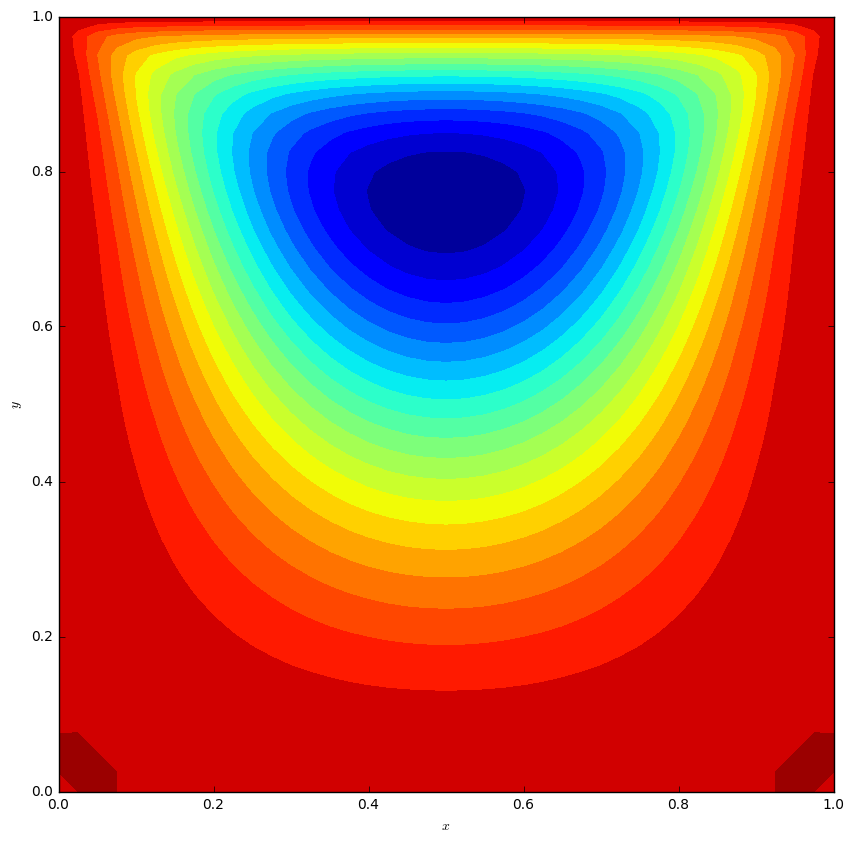

In [8]:
x=np.linspace(0,1,nx)
y=np.linspace(0,1,ny)
pyplot.figure(figsize=(10,10))
pyplot.contourf(x,y,last_psi,20)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar

On peut finalement voir que le résultat obtenu ici est très semblable au résultat attendu, présenté dans le notebook. <br>
On déduit ainsi que le modèle utilisé est satisfaisant.